In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5

#### Stochastic interpolants example

In [2]:
num_target = 2000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 5 * target_samples[jnp.sum(jnp.abs(target_samples),1)>0.5][:num_target]

In [3]:
num_reference = 2000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))

In [4]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(3, 256, key=key1),
                       jax.nn.relu,
                       eqx.nn.Linear(256, 256, key=key2),
                       jax.nn.relu,
                       eqx.nn.Linear(256, 2, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return (1-t)*x + t*y

def It(x,y):
    return -x + y

def gamma(t):
    return jnp.sqrt(2*t*(1-t))

gammadot = vmap(vmap(grad(gamma)))

@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)])
    bhat = jax.vmap(model)(tx)  # vectorise the model over a batch of data


    #loss_value = jnp.mean(jnp.sum(bhat**2,axis=1))
    #dot_term = jnp.mean(jnp.sum((It(x,y) + gammadot(t)*z)*bhat,axis=1))
    #dot_term = 2 * jnp.mean(jnp.sum((It(x,y))*bhat,axis=1))
    #return loss_value - dot_term
    return jnp.mean((bhat - (It(x,y) + gammadot(t)*z))**2)

In [5]:
t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
model = NeuralNetwork(jax.random.PRNGKey(0))
loss(model,t,reference_samples,target_samples,z)

Array(18.33188, dtype=float32)

In [6]:
def evaluate(model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(model,t,x,y,z)
    return avg_loss / 100

In [7]:
def get_trainloader():
    for i in range(10**6):
        trainloader_key = jax.random.PRNGKey(i)
        shuffle_ref_key,shuffle_target_key,normal_key,t_key = jax.random.split(trainloader_key,4)

        ref_batch = jax.random.permutation(shuffle_ref_key,reference_samples)
        
        target_batch = jax.random.permutation(shuffle_target_key,target_samples)

        t_vals = jax.random.uniform(t_key,(len(ref_batch),1))

        z = jax.random.normal(normal_key,ref_batch.shape)

        yield t_vals,ref_batch,target_batch,z

def get_testloader():
    for i in range(100):
        testloader_key = jax.random.PRNGKey(1000*i)
        shuffle_ref_key,shuffle_target_key,normal_key,t_key = jax.random.split(testloader_key,4)
        ref_batch = jax.random.permutation(shuffle_ref_key,reference_samples)
        target_batch = jax.random.permutation(shuffle_target_key,target_samples)
        t_vals = jax.random.uniform(t_key,(len(ref_batch),1))
        z = jax.random.normal(normal_key,ref_batch.shape)
        yield t_vals,ref_batch,target_batch,z

In [10]:
trainloader = get_trainloader()
def train(
  model: NeuralNetwork,
  optim,
  steps,
  print_every
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
        
    
    for step, (t,x,y,z) in zip(range(steps), trainloader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        if train_loss is jnp.nan:
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model
                

In [11]:
learning_rate = 1e-4
optim = optax.adam(learning_rate=learning_rate)
model = NeuralNetwork(jax.random.PRNGKey(420))

model = train(model,optim,steps=5000,print_every=100)

step=0 | train_loss=24.786455 | test_loss= 78.2952
step=100 | train_loss=21.98383 | test_loss= 72.23314
step=200 | train_loss=12.24166 | test_loss= 72.03307
step=300 | train_loss=10.135255 | test_loss= 71.98178
step=400 | train_loss=10.673908 | test_loss= 71.94739
step=500 | train_loss=9.875461 | test_loss= 71.91981
step=600 | train_loss=16.848759 | test_loss= 71.88341
step=700 | train_loss=13.067115 | test_loss= 71.86618
step=749 | train_loss=123.86159 | test_loss= 71.84813


In [12]:
t,x,y,z = next(trainloader)

In [13]:
vmapped_model = vmap(model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_model(jnp.hstack([t_vec,x]))

In [14]:
X0 = reference_samples.copy()
X = X0.copy()
X_hist = []
t = 0
for i in range(100):

    X += 0.01 * dX_t(t,X,None)
    t+=0.01
    X_hist.append(X)

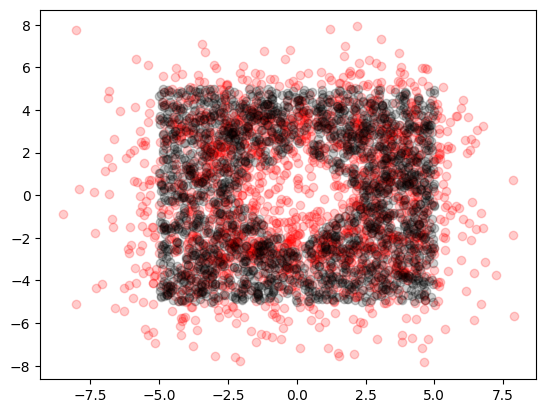

In [15]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)
plt.scatter(target_samples[:,0],target_samples[:,1],c='black',alpha = 0.2)


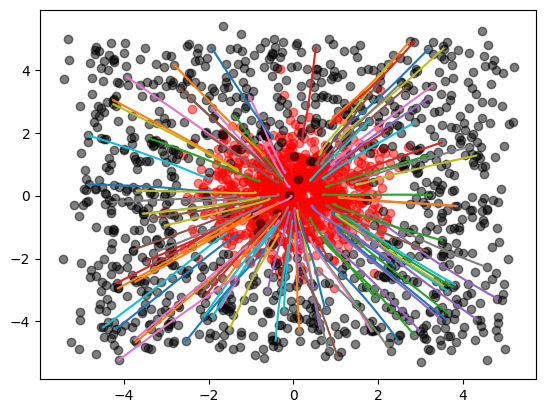

In [90]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(100):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1])

In [48]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=0.99, dt0=0.01, y0=X0)

In [49]:
sol_samples = solution.ys[0]

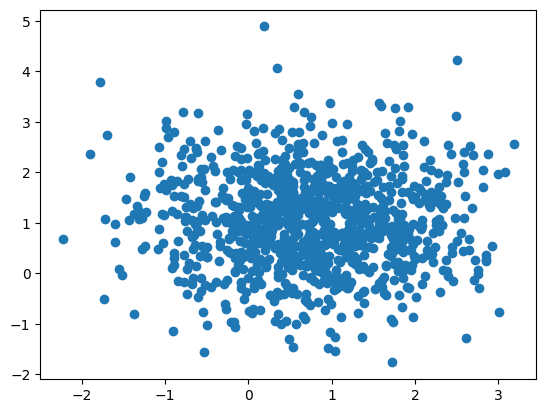

In [50]:
plt.scatter(sol_samples[:,0],sol_samples[:,1])

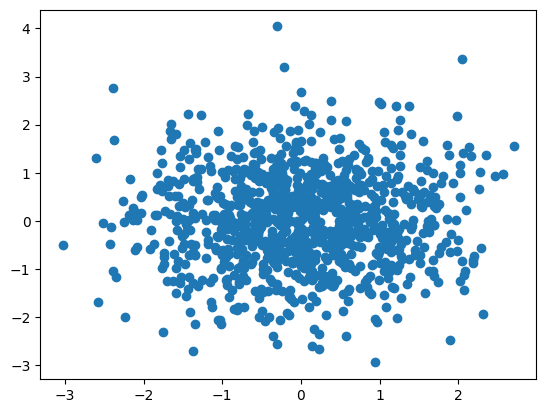

In [51]:
plt.scatter(X0[:,0],X0[:,1])